In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMAGE_SIZE = 512

transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.ColorJitter(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [18]:
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet

dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', target_types='segmentation', download=True)

100%|██████████| 792M/792M [00:33<00:00, 23.5MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 14.4MB/s]


In [20]:
transform = T.Compose(
    [
        T.Resize((128, 128)),
        T.ToTensor(),
    ]
)

target_transform = T.Compose(
    [
        T.Resize((128, 128)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

train_dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', transform=transform, target_transform=target_transform, target_types='segmentation')
val_dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', transform=transform, split='test', target_transform=target_transform, target_types='segmentation')

In [23]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")

Train dataset size: 3680
Val dataset size: 3669


Image shape: torch.Size([3, 128, 128])
Mask shape: torch.Size([1, 128, 128])


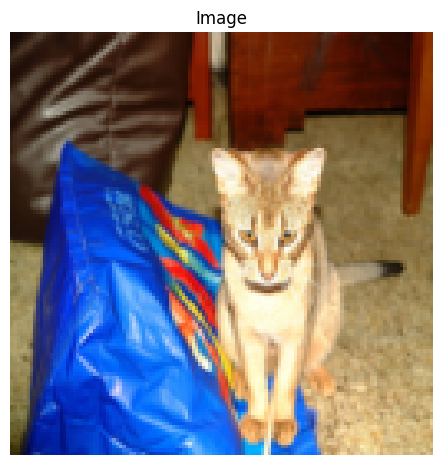

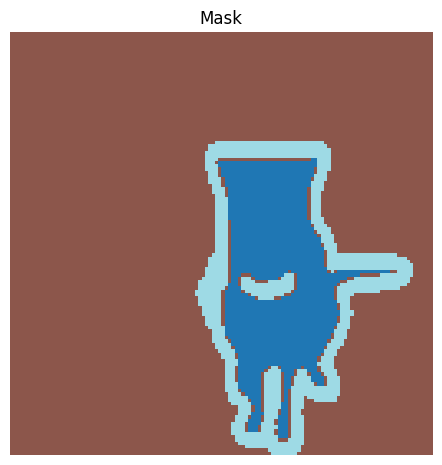

In [37]:
import matplotlib.pyplot as plt

image, mask = train_dataset[5]
print(f'Image shape: {image.shape}')
print(f'Mask shape: {mask.shape}')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title('Image')
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(0), cmap='tab20')
plt.title('Mask')
plt.axis('off')
plt.show()

In [25]:
import torch.nn as nn
import torch

class UNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=21):
    super(UNet, self).__init__()

    def double_conv(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    self.down1 = double_conv(in_channels, 64)
    self.down2 = double_conv(64, 128)
    self.down3 = double_conv(128, 256)
    self.down4 = double_conv(256, 512)

    self.maxpool = nn.MaxPool2d(2)

    self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.up_conv3 = double_conv(512, 256)

    self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.up_conv2 = double_conv(256, 128)

    self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.up_conv1 = double_conv(128, 64)

    self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

  def forward(self, x):
    # Encoder
    conv1 = self.down1(x)
    x = self.maxpool(conv1)

    conv2 = self.down2(x)
    x = self.maxpool(conv2)

    conv3 = self.down3(x)
    x = self.maxpool(conv3)

    x = self.down4(x)

    # Decoder

    x = self.up3(x)
    x = torch.cat([x, conv3], dim=1)
    x = self.up_conv3(x)

    x = self.up2(x)
    x = torch.cat([x, conv2], dim=1)
    x = self.up_conv2(x)

    x = self.up1(x)
    x = torch.cat([x, conv1], dim=1)
    x = self.up_conv1(x)

    x = self.final_conv(x)

    return x

In [26]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [27]:
model = UNet()

In [28]:
#state_dict = torch.load('unet_best.pth')
#model.load_state_dict(state_dict)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [30]:
criterion = nn.CrossEntropyLoss(ignore_index=255)

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

In [32]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Сохраняет модель, если улучшение есть."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [33]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)
early_stop = EarlyStopping(patience=7, verbose=True)

In [34]:
import numpy as np

def compute_metrics(preds, targets, num_classes=21, ignore_index=255):
    preds = preds.view(-1)
    targets = targets.view(-1)

    # Игнорируем пиксели с ignore_index
    mask = targets != ignore_index
    preds = preds[mask]
    targets = targets[mask]

    # Подсчёт точности
    correct = (preds == targets).sum().item()
    total = preds.numel()
    accuracy = correct / total if total > 0 else 0

    # Подсчёт IoU
    iou_per_class = []
    for c in range(num_classes):
        tp = ((preds == c) & (targets == c)).sum().item()
        fp = ((preds == c) & (targets != c)).sum().item()
        fn = ((preds != c) & (targets == c)).sum().item()
        union = tp + fp + fn
        if union == 0:
            iou_per_class.append(float('nan'))  # пропускаем класс без данных
        else:
            iou_per_class.append(tp / union)

    miou = np.nanmean(iou_per_class)
    return accuracy, miou

In [35]:
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

Epoch 1/50 - Val: 100%|██████████| 918/918 [00:40<00:00, 22.49it/s]


Train Loss: 0.4799, Val Loss: 0.4182
Val mIoU: 0.6067
Validation loss decreased (inf --> 0.418158). Saving model...


Epoch 2/50 - Val: 100%|██████████| 918/918 [00:39<00:00, 23.01it/s]


Train Loss: 0.4212, Val Loss: 0.3765
Val mIoU: 0.6339
Validation loss decreased (0.418158 --> 0.376478). Saving model...


Epoch 3/50 - Val: 100%|██████████| 918/918 [00:39<00:00, 23.15it/s]


Train Loss: 0.3879, Val Loss: 0.3695
Val mIoU: 0.6499
Validation loss decreased (0.376478 --> 0.369521). Saving model...


Epoch 4/50 - Val: 100%|██████████| 918/918 [00:40<00:00, 22.94it/s]


Train Loss: 0.3629, Val Loss: 0.3506
Val mIoU: 0.6708
Validation loss decreased (0.369521 --> 0.350641). Saving model...


Epoch 5/50 - Val: 100%|██████████| 918/918 [00:40<00:00, 22.81it/s]


Train Loss: 0.3407, Val Loss: 0.3496
Val mIoU: 0.6612
Validation loss decreased (0.350641 --> 0.349554). Saving model...


Epoch 6/50 - Val: 100%|██████████| 918/918 [00:41<00:00, 22.00it/s]


Train Loss: 0.3212, Val Loss: 0.3264
Val mIoU: 0.6847
Validation loss decreased (0.349554 --> 0.326430). Saving model...


Epoch 7/50 - Val: 100%|██████████| 918/918 [00:40<00:00, 22.86it/s]


Train Loss: 0.3041, Val Loss: 0.3347
Val mIoU: 0.6797
EarlyStopping counter: 1 out of 7


Epoch 8/50 - Val: 100%|██████████| 918/918 [00:40<00:00, 22.71it/s]


Train Loss: 0.2959, Val Loss: 0.3248
Val mIoU: 0.6903
Validation loss decreased (0.326430 --> 0.324833). Saving model...


Epoch 9/50 - Val: 100%|██████████| 918/918 [00:39<00:00, 23.00it/s]


Train Loss: 0.2825, Val Loss: 0.3075
Val mIoU: 0.7026
Validation loss decreased (0.324833 --> 0.307535). Saving model...


Epoch 10/50 - Val: 100%|██████████| 918/918 [00:40<00:00, 22.87it/s]


Train Loss: 0.2697, Val Loss: 0.3235
Val mIoU: 0.6880
EarlyStopping counter: 1 out of 7


Epoch 11/50 - Val: 100%|██████████| 918/918 [00:40<00:00, 22.71it/s]


Train Loss: 0.2595, Val Loss: 0.3055
Val mIoU: 0.7040
Validation loss decreased (0.307535 --> 0.305522). Saving model...


Epoch 12/50 - Val: 100%|██████████| 918/918 [00:39<00:00, 23.00it/s]


Train Loss: 0.2443, Val Loss: 0.3129
Val mIoU: 0.7009
EarlyStopping counter: 1 out of 7


Epoch 13/50 - Val: 100%|██████████| 918/918 [00:39<00:00, 23.16it/s]


Train Loss: 0.2363, Val Loss: 0.3039
Val mIoU: 0.7136
Validation loss decreased (0.305522 --> 0.303893). Saving model...


Epoch 14/50 - Val: 100%|██████████| 918/918 [00:39<00:00, 23.06it/s]


Train Loss: 0.2264, Val Loss: 0.3219
Val mIoU: 0.6968
EarlyStopping counter: 1 out of 7


Epoch 15/50 - Val: 100%|██████████| 918/918 [00:40<00:00, 22.93it/s]


Train Loss: 0.2195, Val Loss: 0.2990
Val mIoU: 0.7105
Validation loss decreased (0.303893 --> 0.298984). Saving model...


Epoch 16/50 - Val: 100%|██████████| 918/918 [00:40<00:00, 22.68it/s]


Train Loss: 0.2088, Val Loss: 0.3088
Val mIoU: 0.7161
EarlyStopping counter: 1 out of 7


Epoch 17/50 - Val: 100%|██████████| 918/918 [00:39<00:00, 23.11it/s]


Train Loss: 0.1997, Val Loss: 0.3119
Val mIoU: 0.7123
EarlyStopping counter: 2 out of 7


Epoch 18/50 - Val: 100%|██████████| 918/918 [00:40<00:00, 22.82it/s]


Train Loss: 0.1986, Val Loss: 0.3787
Val mIoU: 0.6968
EarlyStopping counter: 3 out of 7


Epoch 19/50 - Val: 100%|██████████| 918/918 [00:42<00:00, 21.81it/s]


Train Loss: 0.1927, Val Loss: 0.3296
Val mIoU: 0.7008
EarlyStopping counter: 4 out of 7


Epoch 20/50 - Val: 100%|██████████| 918/918 [00:41<00:00, 21.97it/s]


Train Loss: 0.1664, Val Loss: 0.2996
Val mIoU: 0.7303
EarlyStopping counter: 5 out of 7


Epoch 21/50 - Val: 100%|██████████| 918/918 [00:39<00:00, 23.01it/s]


Train Loss: 0.1580, Val Loss: 0.3092
Val mIoU: 0.7292
EarlyStopping counter: 6 out of 7


Epoch 22/50 - Val: 100%|██████████| 918/918 [00:40<00:00, 22.95it/s]


Train Loss: 0.1547, Val Loss: 0.3148
Val mIoU: 0.7288
EarlyStopping counter: 7 out of 7
Early stopping


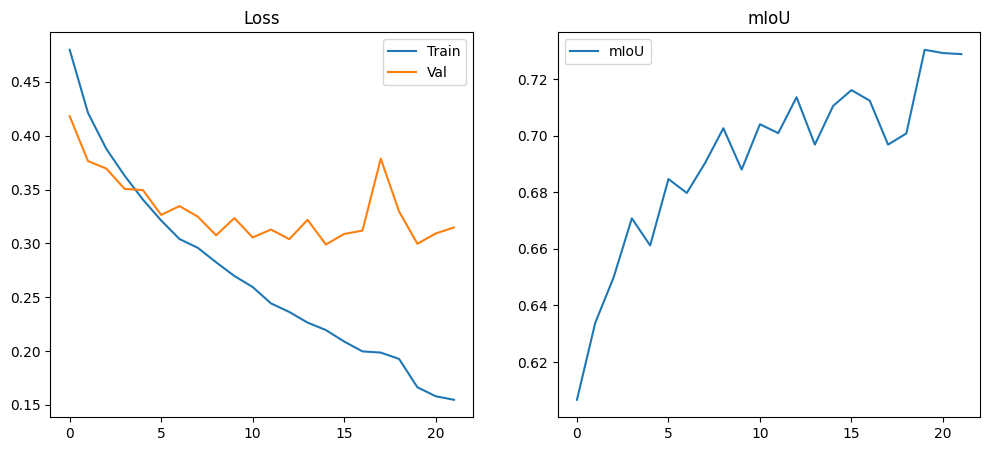

In [41]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
val_miou = []

num_epochs = 50
best_miou = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
        images = images.to(device)
        masks = masks.to(device)

        masks = masks.squeeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0.0
    total_miou = 0.0
    count = 0

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
            images = images.to(device)
            masks = masks.to(device)
            masks = masks.squeeze(1)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            for pred, target in zip(preds, masks):
                _, miou = compute_metrics(pred, target)
                total_miou += miou
                count += 1

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_miou = total_miou / count

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_miou.append(avg_miou)

    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    print(f"Val mIoU: {avg_miou:.4f}")

    scheduler.step(avg_val_loss)
    early_stop(avg_val_loss, model)

    if early_stop.early_stop:
        print("Early stopping")
        break

# Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_miou, label='mIoU')
plt.title("mIoU")
plt.legend()
plt.show()

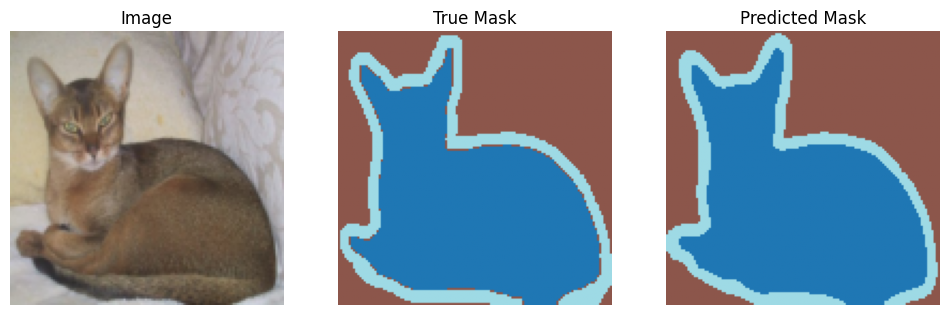

In [55]:
def plot_result(model, dataset, idx=0):
    model.eval()
    image, mask = dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0))  # CHW -> HWC
    plt.title("Image")
    plt.axis('off')

    mask = mask.squeeze(0)
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='tab20')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='tab20')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()

plot_result(model, train_dataset, 11)